# Project - Windspeed Analysis

Author: Céaman Collins

In this notebook I will be investigating the wind speed recordings from Mace Head Atmospheric Research Station, Carna, County Galway.

![Mace Head](images/Location-of-the-Mace-Head-research-station-on-the-west-coast-of-Ireland.png)

## Importing Packages

The first step as with most projects is to import the packages that will be used in the investigation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

## Importing Data

The next step is to import the data. 

In [2]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/hly275.csv'
mace_head = pd.read_csv(url, parse_dates=['date'], index_col='date', skiprows=17, low_memory=False, date_format='%d-%b-%Y %H:%M')

Let's have a look at our data frame.

In [3]:
mace_head.head()

ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
date                                                                         
2003-08-13 01:00:00   -1           4           4                             
2003-08-13 02:00:00   -1           4           4                             
2003-08-13 03:00:00   -1           4           4                             
2003-08-13 04:00:00   -1           4           4                             
2003-08-13 05:00:00   -1           4           4                             

                     ind.3 wdsp  ind.4 wddir  
date                                          
2003-08-13 01:00:00      7           7        
2003-08-13 02:00:00      7           7        
2003-08-13 03:00:00      7           7        
2003-08-13 04:00:00      7           7        
2003-08-13 05:00:00      7           7

## Cleaning the Data

There seem to be some empty values in the data set. We can replace these space characters with `NaN` objects.

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
mace_head.replace(to_replace=' ', value=np.nan, inplace=True)

Let's have another look.

In [5]:
wind_speed = mace_head.loc[:, ['wdsp']]
wind_speed.isna().sum()


wdsp    1296
dtype: int64

We can now drop any rows that are missing values.

In [6]:
wind_speed.dropna(inplace=True)

In [7]:
wind_speed.head()

wdsp
date                    
2003-08-14 01:00:00    6
2003-08-14 02:00:00    4
2003-08-14 03:00:00    3
2003-08-14 04:00:00    5
2003-08-14 05:00:00    6

We can now change the data type of the whole column to `int64`. This will help with performing calculations later.

In [8]:
wind_speed['wdsp'] = pd.to_numeric(wind_speed['wdsp'])

In [9]:
wind_speed.head()

wdsp
date                     
2003-08-14 01:00:00     6
2003-08-14 02:00:00     4
2003-08-14 03:00:00     3
2003-08-14 04:00:00     5
2003-08-14 05:00:00     6

## Calculating monthly mean wind speed

We can get the monthly average wind speed by resampling the data.

In [10]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
wind_speed_monthly_average = wind_speed['wdsp'].resample('MS').mean()

In [11]:
wind_speed_monthly_average.tail()

date
2025-08-01    13.763441
2025-09-01    17.184722
2025-10-01    17.491935
2025-11-01    15.705556
2025-12-01    19.000000
Freq: MS, Name: wdsp, dtype: float64

### Generating Graphs

One of the most informative plots is a box plot - showing median, quartile ranges and even outliers.

The following documentation helped me to annotate the plot:

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch

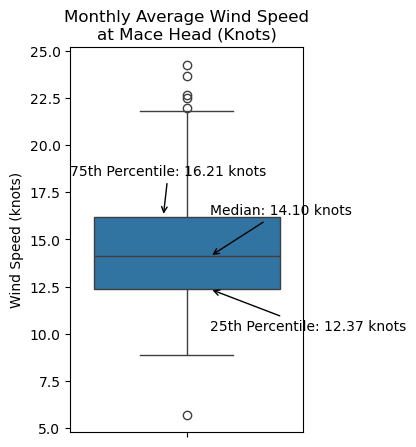

In [12]:
fig, ax = plt.subplots(figsize=(3,5))
boxplot = sns.boxplot(data=wind_speed_monthly_average, ax=ax)
plt.title('Monthly Average Wind Speed\nat Mace Head (Knots)')
plt.ylabel('Wind Speed (knots)')

plt.annotate(f'Median: {wind_speed_monthly_average.median():.2f} knots', 
             xy=(0.1, wind_speed_monthly_average.median()), 
             xytext=(0.1, wind_speed_monthly_average.median()+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))
percentile_25 = wind_speed_monthly_average.quantile(0.25)
plt.annotate(f'25th Percentile: {percentile_25:.2f} knots', 
             xy=(0.1, percentile_25),
             xytext=(0.1, percentile_25-2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))
percentile_75 = wind_speed_monthly_average.quantile(0.75)
plt.annotate(f'75th Percentile: {percentile_75:.2f} knots', 
             xy=(-0.1, percentile_75),
             xytext=(-0.5, percentile_75+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'))

plt.show()

We can also look at it on a line plot.

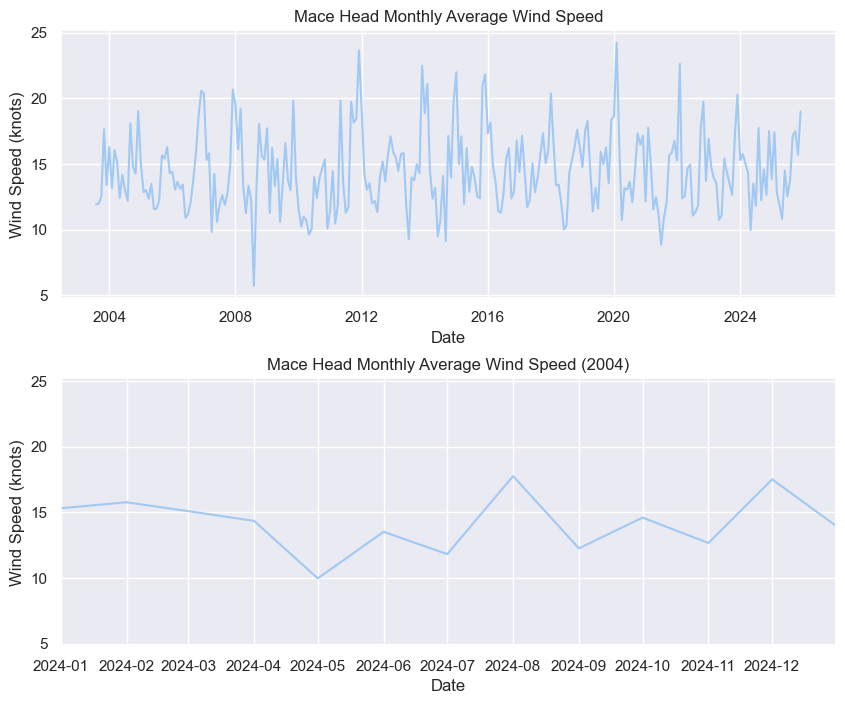

In [13]:
sns.set_theme('notebook', palette='pastel')
_, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
lineplot = sns.lineplot(data=wind_speed_monthly_average, ax=axes[0])
lineplot.set_title('Mace Head Monthly Average Wind Speed')
lineplot.set_xlabel('Date')
lineplot.set_ylabel('Wind Speed (knots)')
zoom = sns.lineplot(data=wind_speed_monthly_average, ax=axes[1])
zoom.set_title('Mace Head Monthly Average Wind Speed (2004)')
zoom.set_xlabel('Date')
zoom.set_ylabel('Wind Speed (knots)')
zoom.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 12, 31))
plt.show()
plt.close()

We can use relplot to plot the monthly average wind speeds on top of each other and colour them by year to get a better view of the seasonal highs and lows over a year.

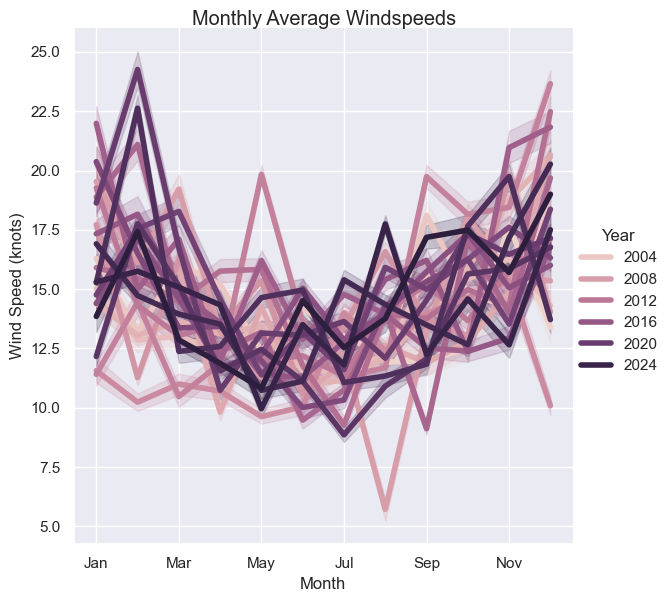

In [14]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp',
                  kind='line', height=6, aspect=1, 
                  hue=wind_speed.index.year, linewidth=4)
rel.figure.suptitle('Monthly Average Windspeeds', y=1)
rel.set_xlabels('Month')
rel.set_ylabels('Wind Speed (knots)')
rel.set(xticks=list(months.keys())[::2],
        xticklabels=list(months.values())[::2])
rel.legend.set_title('Year')
plt.show()
plt.close()

There seems to be a definite seasonal curve to the wind speeds.

We can also view the years individually, with the other years plotted behind them for context.

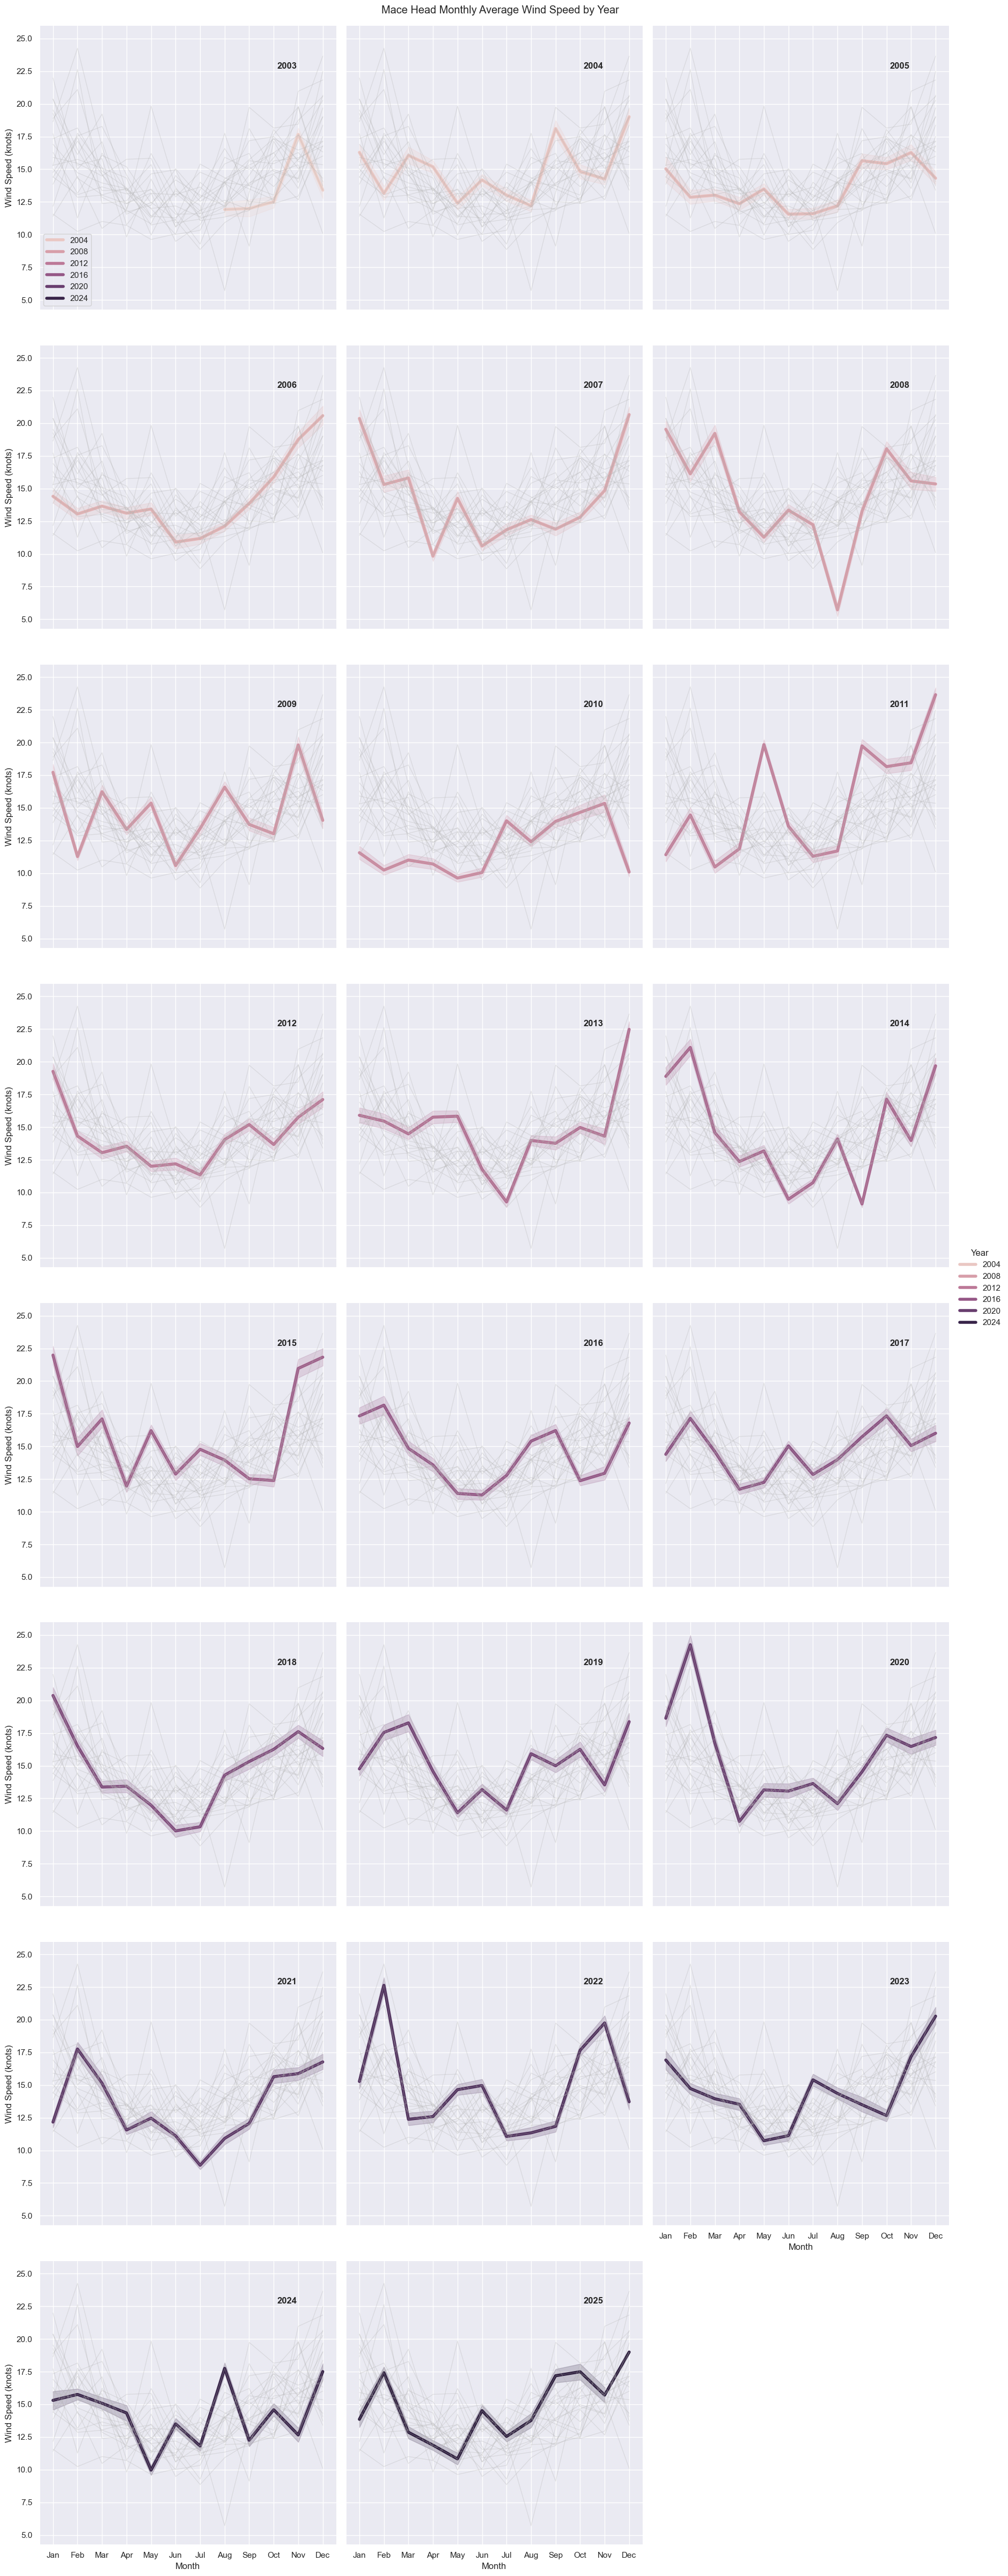

In [15]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp', kind='line',
                   height=6, aspect=1, hue=wind_speed.index.year, 
                   col=wind_speed.index.year, col_wrap=3, linewidth=4)
rel.set_axis_labels('Month', 'Wind Speed (knots)')
rel.set(xticks=list(months.keys()), xticklabels=list(months.values()))
rel.figure.suptitle('Mace Head Monthly Average Wind Speed by Year', y=1)
rel.legend.set_title('Year')

for year, ax in rel.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")
    ax.title.set_text('')

    sns.lineplot(
        data=pd.DataFrame(wind_speed_monthly_average), 
        x=wind_speed_monthly_average.index.month, y='wdsp', 
        units=wind_speed_monthly_average.index.year,
        estimator=None, color=".7", linewidth=1, ax=ax, alpha=0.3
    )


It is incredible to see there is so much data in this dataset. We can now see which years had irregularly high or low wind speeds in context. Some years show the recognisable curve we identified in the previous figure, but some jitter unexpectedly.

## Machine Learning

In this section I will set about creating a model of my data using ARIMA machine learning models. This will take periodicity into account to give us the general model of average wind speeds by month.

I use several guides for this section. They can be found here:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.geeksforgeeks.org/data-science/model-selection-for-arima/

https://www.datacamp.com/tutorial/arima

### Investigation

The first investigation we can perform is whether or not differencing is required for this dataset.

In [16]:
result = adfuller(wind_speed_monthly_average)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -4.146203
p-value: 0.000812
Series is stationary; no differencing needed.


C:\Users\luxxx\AppData\Local\Temp\ipykernel_39972\2223406745.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)


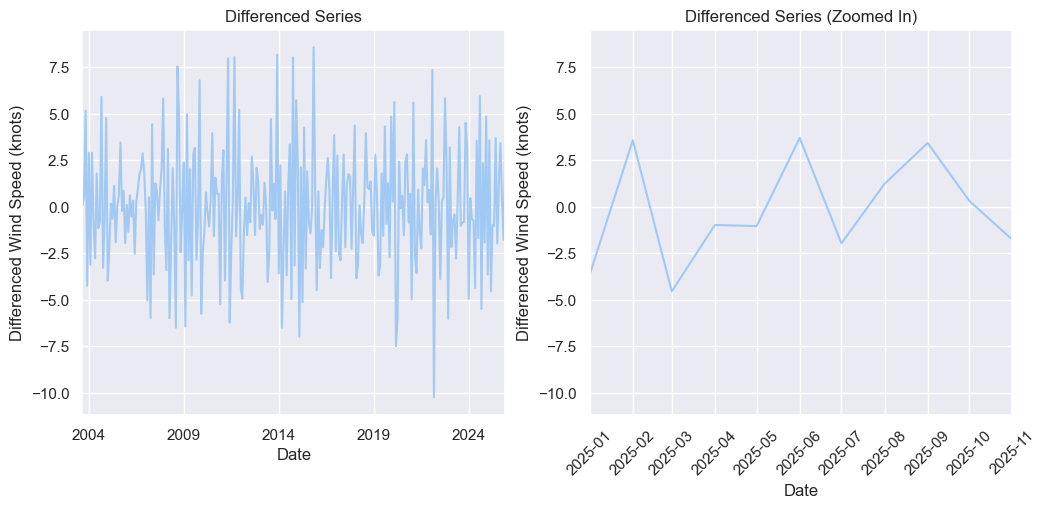

ADF Statistic (differenced): -10.666479
p-value (differenced): 0.000000


In [17]:
ts_diff = wind_speed_monthly_average.diff().dropna()

fig, axes = plt.subplots(1,2, figsize=(12,5))
ts_diff.plot(title='Differenced Series', ax=axes[0], ylabel='Differenced Wind Speed (knots)', xlabel='Date')
line = sns.lineplot(x=ts_diff.index, y=ts_diff.values, ax=axes[1])
axes[1].set_xlim(dt.datetime(2025, 1, 1), dt.datetime(2025, 11, 1))
axes[1].set(title='Differenced Series (Zoomed In)', ylabel='Differenced Wind Speed (knots)', xlabel='Date')
axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)
plt.show()

result_diff = adfuller(ts_diff)
print('ADF Statistic (differenced): %f' % result_diff[0])
print('p-value (differenced): %f' % result_diff[1])

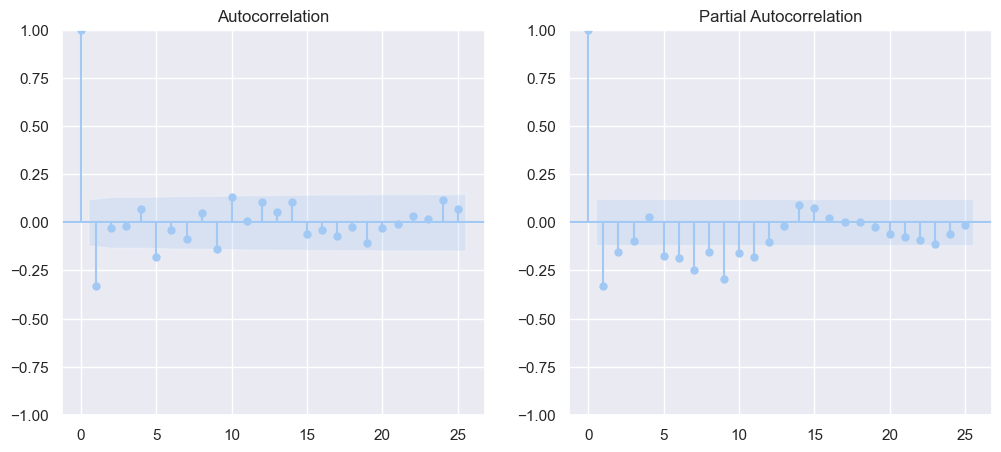

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

It looks like no differencing is required according to the AD Fuller tests performed on the data.

### Preprocessing

We first need to separate our data into three separate groups. A training set, a validation set and a test set. These different groups will be used to train our model and evaluate its effectiveness in predicting future values.

In [19]:
y_train_full, y_test = train_test_split(wind_speed_monthly_average, test_size=0.2, shuffle=False)
y_train, y_validation = train_test_split(y_train_full, test_size=0.2, shuffle=False)

### Parameter Tuning

In order to get a good picture of which parameters to use for our model, we can run a series of tests.

There are several parameters for this model.

> The p parameter represents the number of lagged observations included in the autoregressive part of the model. For example, if p=2, the model uses the two most recent time steps (t-1 and t-2) to predict the current value (t). This is useful when past values directly influence future values, such as in stock prices where recent trends might persist. The d parameter determines how many times the data is differenced to remove non-stationarity (e.g., trends or changing variance). If d=1, the model uses the difference between consecutive data points (t and t-1). For instance, if monthly sales data has a linear trend, differencing once can stabilize the mean. The q parameter specifies the number of lagged forecast errors in the moving average component. A q=1 model uses the error from the previous prediction to adjust the current forecast, which helps account for sudden shocks or anomalies in the data, like a spike in website traffic due to a viral event.

[Source](https://blog.milvus.io/ai-quick-reference/what-is-an-arima-pdq-model-and-what-do-the-parameters-represent)

The s parameter is the length of the seasonal period. 

The parameters I will be tuning are P and Q, as our investigation told us that no differencing will be required and we already know that monthly data has a seasonal periodicity of 12.


I was getting a ConvergenceWarning, and upon investigation it was suggested to include a max iterations keyword argument in my `model.fit`. This resource was helpful to correct the error.

https://stackoverflow.com/questions/52872724/convergencewarning-maximum-likelihood-optimization-failed-to-converge

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [ ]:
p = range(0, 6)
d = [0]
q = range(0, 4)
s = [12]
pdqs = list(itertools.product(p, d, q, s))

best_aic = np.inf
best_order = None
best_model = None
lowest_rmse = np.inf
lowest_error_order = None
history = {}

for order in pdqs:
    try:
        model = ARIMA(
            y_train, seasonal_order=order, trend='ct', freq='MS'
            )
        results = model.fit(method_kwargs={'maxiter':300})
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        rmse = sqrt(mean_squared_error(
            y_validation, results.forecast(steps=len(y_validation))
            ))
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            lowest_error_order = order

    except Exception as e:
        print(f'Error for order {order}: {e}')
    finally: 
        history[order] = {'aic': results.aic, 'rmse': rmse}
        

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')
print(f'Lowest RMSE order: {lowest_error_order} with RMSE: {lowest_rmse}')

Best ARIMA order: (1, 0, 1, 12) with AIC: 834.430209020023
Lowest RMSE order: (3, 0, 1, 12) with RMSE: 2.3324377457305503


After some testing, the 

In [41]:
history

level_0  level_1  level_2  level_3         aic      rmse
0         0        0        0       12  868.720214  2.918289
1         0        0        1       12  859.119868  2.890814
2         0        0        2       12  851.289464  2.829293
3         0        0        3       12  851.818217  2.768483
4         1        0        0       12  853.622211  2.826288
5         1        0        1       12  834.430209  2.338580
6         1        0        2       12  836.414098  2.339625
7         1        0        3       12  838.351043  2.333581
8         2        0        0       12  847.044767  2.614682
9         2        0        1       12  836.419510  2.339120
10        2        0        2       12  838.385161  2.340215
11        2        0        3       12  839.273470  2.338181
12        3        0        0       12  848.721604  2.560940
13        3        0        1       12  838.394297  2.332438
14        3        0        2       12  840.362456  2.339308
15        3        0        3       12  837.814199  2.405277
16        4        0        0       12  848.032333  2.424495
17        4        0        1       12  836.843710  2.417367
18        4        0        2       12  834.772596  2.493282
19        4        0        3       12  841.509433  2.360746
20        5        0        0       12  848.225508  2.332446
21        5        0        1       12  837.956382  2.412131
22        5        0        2       12  840.101323  2.440302
23        5        0        3       12  838.557116  2.507559

In [36]:
history = pd.DataFrame.from_dict(history, orient='index')
history.reset_index(inplace=True)

TypeError: 'numpy.ndarray' object is not callable

We got the best fit with the highest values of our parameters, which is unsurpising, however we got the lowest error for the simplest model which is also unsurprising. The model will overfit to a more complex model meaning the predictions will be too close to our training data to effectively make predictions about the validation data. A simpler model, while running the risk of underfitting, has yielded the lowest mean squared error. I have to go with the parameters that yield the lowest error values. 

<Axes: >

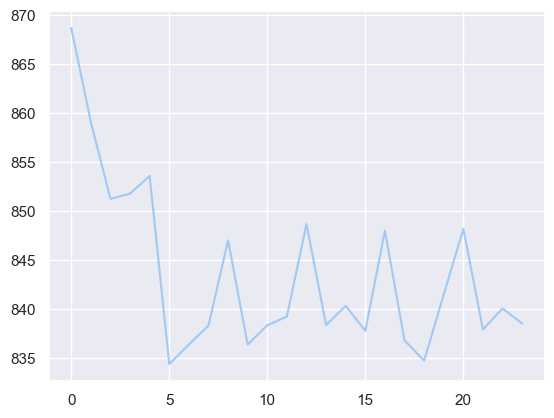

In [ ]:
history['aic'].plot()

<Axes: >

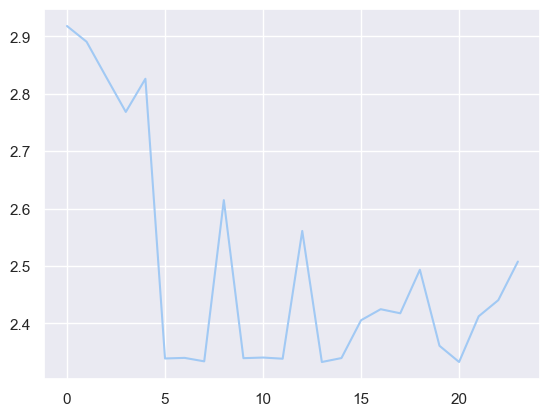

In [35]:
history['rmse'].plot()

### Fitting the model

In [ ]:
model = ARIMA(y_train, seasonal_order=(1,1,1,12), trend='ct', freq='MS')
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                     wdsp   No. Observations:                  171
Model:             ARIMA(1, 0, [1], 12)   Log Likelihood                -383.548
Date:                  Mon, 08 Dec 2025   AIC                            777.097
Time:                          02:27:44   BIC                            792.410
Sample:                      08-01-2003   HQIC                           783.316
                           - 10-01-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8880     35.915      0.387      0.699     -56.504      84.280
x1             0.0069      0.077      0.090      0.928      -0.143       0.157
ar.S.L12       0.9694      0.030    

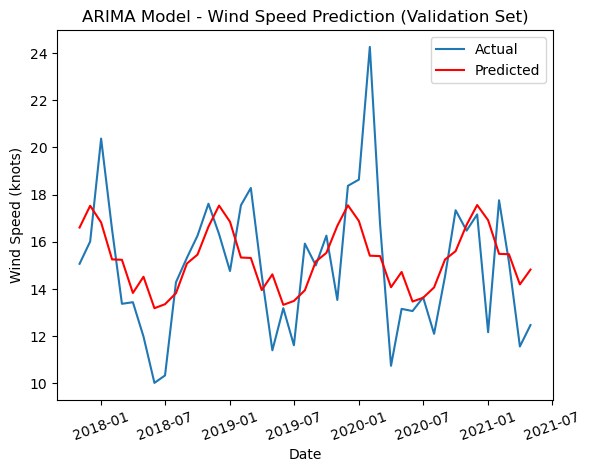

In [ ]:
y_hat_validation = model_fit.forecast(steps=len(y_validation))
plt.plot(y_validation.index, y_validation, label='Actual')
plt.plot(y_validation.index, y_hat_validation, label='Predicted', color='red')
plt.title('ARIMA Model - Wind Speed Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.legend()

In [ ]:
print(f'AIC: {model_fit.aic}, BIC: {model_fit.bic}')

AIC: 777.096894506459, BIC: 792.4098696715938


In [ ]:
print(f'RMSE = {sqrt(mean_squared_error(y_validation, y_hat_validation))}')

RMSE = 2.381004254927634


TO DO:

https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
https://www.geeksforgeeks.org/python/how-to-calculate-mape-in-python/
https://stats.stackexchange.com/questions/360507/can-i-overfit-an-arima-model

The metrics look pretty solid. Let's see how this stands up against the test set.

[This geeks for geeks page](https://www.geeksforgeeks.org/python/how-to-change-index-values-in-pandas/) helped me to set the correct index for the predicted values.

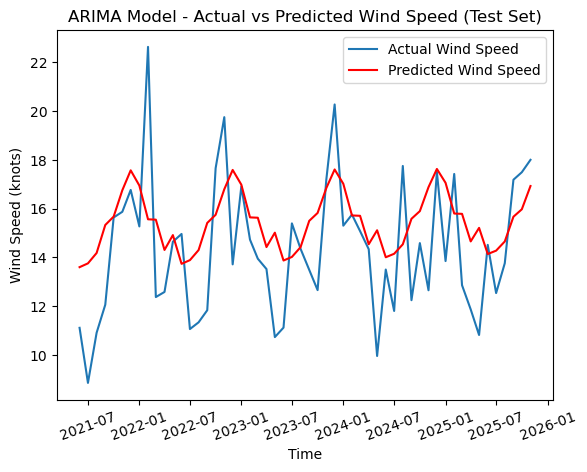

In [ ]:
y_hat_test = pd.DataFrame(
    model_fit.forecast(
        steps=(len(y_test)+len(y_validation))
        )[len(y_validation):]
    ).set_index(y_test.index)
plt.plot(y_test, label='Actual Wind Speed')
plt.plot(y_hat_test, color='red', label='Predicted Wind Speed')
plt.title('ARIMA Model - Actual vs Predicted Wind Speed (Test Set)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.ylabel('Wind Speed (knots)')
plt.legend()
plt.show()

In [ ]:
print(f'RMSE for test set: {sqrt(mean_squared_error(y_test, y_hat_test))}')

RMSE for test set: 2.6015255549727674


It seems that the periodicity has been captured very well but the highs and lows have not been predicted particularly well and our RMSE is in fact higher than with our validation set.


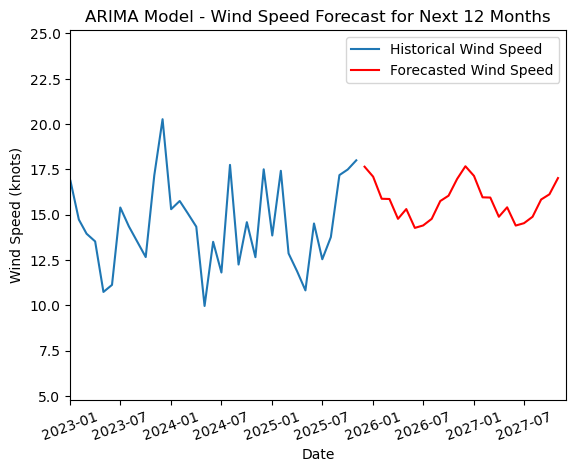

In [ ]:
prediction = pd.DataFrame(
                    model_fit.forecast(
                        steps=(len(y_test)+len(y_validation)+24)
                    )[len(y_validation)+len(y_test):]
                ).set_index(
                    pd.date_range(
                        start=y_test.index[-1] + pd.DateOffset(months=1),
                        periods=24, freq='MS'
                    )
                )
plt.plot(mace_head_wdsp_resampled, label='Historical Wind Speed')
plt.plot(prediction, color='red', label='Forecasted Wind Speed')
plt.title('ARIMA Model - Wind Speed Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.xlim(dt.datetime(2023, 1, 1), dt.datetime(2027, 12, 1))
plt.legend()
plt.show()


## SARIMAX

https://www.geeksforgeeks.org/artificial-intelligence/what-is-an-arimax-model/

## Tensor Flow

https://www.tensorflow.org/tutorials/structured_data/time_series

# End

notes:

plot model loss and accuracy
distribution of averages, by month, is it normal mean and variance of each month, year
t test to see if months are the same or different
strip plots seaborn
box plots

https://thelinuxcode.com/seaborn-lineplot/

https://duckduckgo.com/?q=cross+validation+ARIMA&ia=web

https://www.tensorflow.org/tutorials/structured_data/time_series